In [1]:
import os
os.environ["WEBBPSF_PATH"] = '../webbpsf-data'
os.environ["WEBBPSF_EXT_PATH"] = '../webbpsf-data'
os.environ["PYSYN_CDBS"] = "../cdbs"

from astropy.io import fits

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.40'

jax.config.update("jax_enable_x64", True)

#### Loading Files

In [2]:
import pandas as pd

# GPI Image Initial Parameter Reference

# Name             Radius   Inclination  Position Angle Distance  Knots                                                  
# hd145560_H_pol    85.3         43.9        221.5        120.44      7
# hd146897_H_pol    85.0         84.0        293.9        131.50      9
# ceant_H_pol       29.8         13.1        271.0         34.03      7
# hd111520_H_pol    81.0         88.0        165.0        108.94      7
# hd115600_H_pol    46.0         80.0         27.5        109.62      7
# hd129590_H_pol    66.9         75.7        121.7        136.04      9
# hd117214_H_pol    60.2         71.0        359.8        107.61     11
# hd35841_H_pol     60.3         84.9        345.8        103.68      7
# hd30447_H_pol     83.0         83.0         32.3         80.54      7
# hd32297_H_pol     98.4         88.4         47.9        132.79     13
# hd110058_H_pol    39.0         84.0        335.0        129.98      5
# hd111161_H_pol    72.4         62.1        263.2        109.43      7
# hd157587_H_pol    79.0         70.0        127.0        100.51      7
# hr4796a_H_pol     78.5         76.5         26.1         72.78     11
# hd131835_H_pol   107.7         75.1         61.4        133.65      7
# hd106906_H_pol    72.3         84.6        104.2        103.33      8
# hd114082_H_pol    30.7         83.3        285.7         95.65      5
# hd191089_H_pol    43.9         59.0         70.0         50.13     13
# hd156623_H_pol    80.2         34.9        280.9        111.75     11

row = {'Name': 'hr4796a_H_pol', 'Radius': 78.5, 'Inclination': 76.5, "Position Angle": 26.1, "Distance": 72.78, "Knots": 7,}

In [3]:
import sys
sys.path.append('..')

### Processing Fits File

webbpsf_ext log messages of level WARN and above will be shown.
webbpsf_ext log outputs will be directed to the screen.
Could not import CuPy. Setting: use_gpu=False (i.e., using CPU operations).
Filename: ../test_images/hr4796a_H_pol.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     391   ()      
  1  SCI           1 ImageHDU       135   (281, 281, 4)   float32   
  2  DQ            3 ImageHDU        64   (281, 281, 2)   uint8   


Text(0.5, 1.0, 'Image from Fits File')

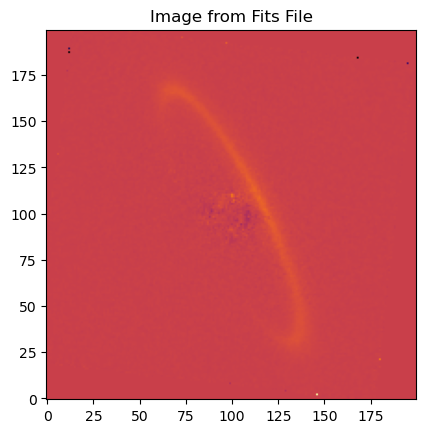

In [4]:
from optimization.optimize_framework import OptimizeUtils

fits_image_filepath = "../test_images/" + row['Name'] + ".fits"
hdul = fits.open(fits_image_filepath)

#Displays File Info
hdul.info()

# Gets Image
target_image = OptimizeUtils.process_image(hdul['SCI'].data[1,:,:], bounds=(40, 240, 40, 240))

# Displays Image
plt.imshow(target_image, origin='lower', cmap='inferno')
plt.title("Image from Fits File")

## Getting Optimal Disk Fit

In [5]:
from optimization.optimize_framework import Optimizer, OptimizeUtils
from disk_model.objective_functions import objective_model, objective_ll, objective_fit, Parameter_Index
from disk_model.SLD_ojax import ScatteredLightDisk
from disk_model.SLD_utils import *

### Getting Optimal Fit

In [6]:

target_image = OptimizeUtils.process_image(hdul['SCI'].data[1,:,:], bounds=(40, 240, 40, 240))
err_map = OptimizeUtils.process_image(OptimizeUtils.create_empirical_err_map(hdul['SCI'].data[2,:,:]), bounds=(40, 240, 40, 240)) #, outlier_pixels=[(57, 68)]))

In [ ]:
start_disk_params = Parameter_Index.disk_params.copy()
start_spf_params = InterpolatedUnivariateSpline_SPF.params.copy()
start_psf_params = EMP_PSF.params.copy()
start_stellar_psf_params = LinearStellarPSF.params.copy()
start_misc_params = Parameter_Index.misc_params.copy()

start_disk_params = Parameter_Index.disk_params.copy()
start_disk_params['sma'] = row["Radius"]
start_disk_params['inclination'] = row["Inclination"]
start_disk_params['position_angle'] = row["Position Angle"]

start_spf_params['num_knots'] = 7 # int(row["Knots"])

start_misc_params['distance'] = row["Distance"]
start_misc_params['nx'] = 200
start_misc_params['ny'] = 200

start_disk_params['x_center'] = start_misc_params['nx']/2
start_disk_params['y_center'] = start_misc_params['ny']/2

opt = Optimizer(ScatteredLightDisk, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, EMP_PSF,
                start_disk_params, start_spf_params, start_psf_params, start_misc_params)

opt.inc_bound_knots() # call this method only if you have a good predifined inclination, otherwise don't use it
opt.initialize_knots(target_image)

In [8]:
opt.jit_compile_model()
opt.jit_compile_gradient(target_image, err_map)

In [9]:
print(opt.log_likelihood(target_image, err_map))
opt.get_gradient(['sma', 'alpha_in', 'knot_values'], target_image, err_map)

-134465.4024462257


[Array(1022.88335491, dtype=float64),
 Array(785.47912708, dtype=float64),
 Array([ 733.78085374, 3964.91101634, 4209.26264345, 3213.59229793,
        1800.43937249,  218.115939  , -216.48837491], dtype=float64)]

Text(0.5, 1.0, 'Initial Guess, Log-Likelihood: -134465.4024462257')

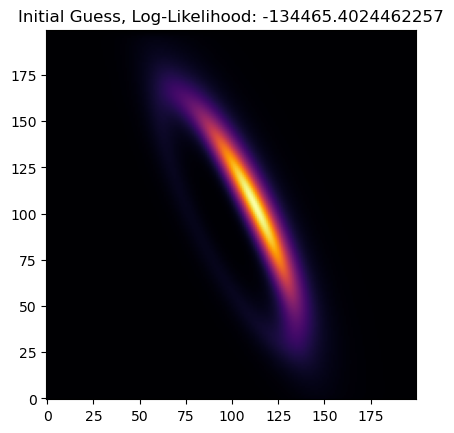

In [10]:
plt.imshow(opt.get_model(), origin='lower', cmap='inferno')
plt.title("Initial Guess, Log-Likelihood: " + str(opt.log_likelihood(target_image, err_map)))

In [11]:
opt.print_params()

Disk Params: {'accuracy': 0.005, 'alpha_in': 5, 'alpha_out': -5, 'sma': 78.5, 'e': 0.0, 'ksi0': 3.0, 'gamma': 2.0, 'beta': 1.0, 'rmin': 0.0, 'dens_at_r0': 1.0, 'inclination': 76.5, 'position_angle': 26.1, 'x_center': 100.0, 'y_center': 100.0, 'halfNbSlices': 25, 'omega': 0.0}
SPF Params: {'backscatt_bound': Array(-0.97236992, dtype=float64, weak_type=True), 'forwardscatt_bound': Array(0.97236992, dtype=float64, weak_type=True), 'num_knots': 7, 'knot_values': Array([9.55356017, 2.99389941, 1.56868337, 1.        , 0.70763107,
       0.53436262, 0.42183294], dtype=float64)}
PSF Params: {'scale_factor': 1.0, 'offset': 1.0}
Stellar PSF Params: None
Misc Params: {'distance': 72.78, 'pxInArcsec': 0.01414, 'nx': 200, 'ny': 200, 'halfNbSlices': 25, 'flux_scaling': Array(3032.50689332, dtype=float64)}


In [12]:
jax.config.update('jax_debug_nans', True)
jax.config.update('jax_debug_infs', True)

In [13]:
# Running optimization method
# fit_keys = ['alpha_in', 'alpha_out', 'sma', 'inclination', 'position_angle', 'x_center', 'y_center', 'e']
fit_keys = ['alpha_in', 'alpha_out', 'sma', 'inclination', 'position_angle', 'x_center', 'y_center', 'knot_values', 'e']
logscaled_params = ['knot_values']
array_params = ['knot_values']
bounds = ([0.1, -15, 0, 0, 0, 90, 90, np.zeros(7), 0],
          [20, -0.1, 150, 180, 400, 110, 110, 1e4*np.ones(7), 1])

opt.scipy_bounded_optimize(fit_keys, bounds, logscaled_params, array_params, target_image, err_map, use_grad = True, disp_soln = True, iters = 2000)
optimal_image = opt.get_model()

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 97154.41722384335
        x: [ 2.000e+01 -1.274e+01 ... -2.944e+00  0.000e+00]
      nit: 389
      jac: [-2.567e+01 -7.585e-01 ...  2.279e-01  1.004e+04]
     nfev: 502
     njev: 502
 hess_inv: <15x15 LbfgsInvHessProduct with dtype=float64>


In [14]:
print(opt._get_raw_gradient(target_image, err_map))

(Array([-7.05301344e+00,  2.56693970e+01,  7.58512002e-01,  8.35172476e-01,
       -1.00384093e+04, -1.27908005e+02, -6.85936622e+01,  9.12128518e+01,
        0.00000000e+00,  2.52924474e+00,  3.25484866e-01, -1.45226088e+00,
       -1.92500094e-01, -2.66697919e-01,  0.00000000e+00,  0.00000000e+00],      dtype=float64), Array([ 0.00582905, -0.01456193, -0.05751447,  0.25743149,  0.16675173,
        0.32695131, -4.32650472], dtype=float64), Array([0., 0.], dtype=float64), Array(0., dtype=float64, weak_type=True))


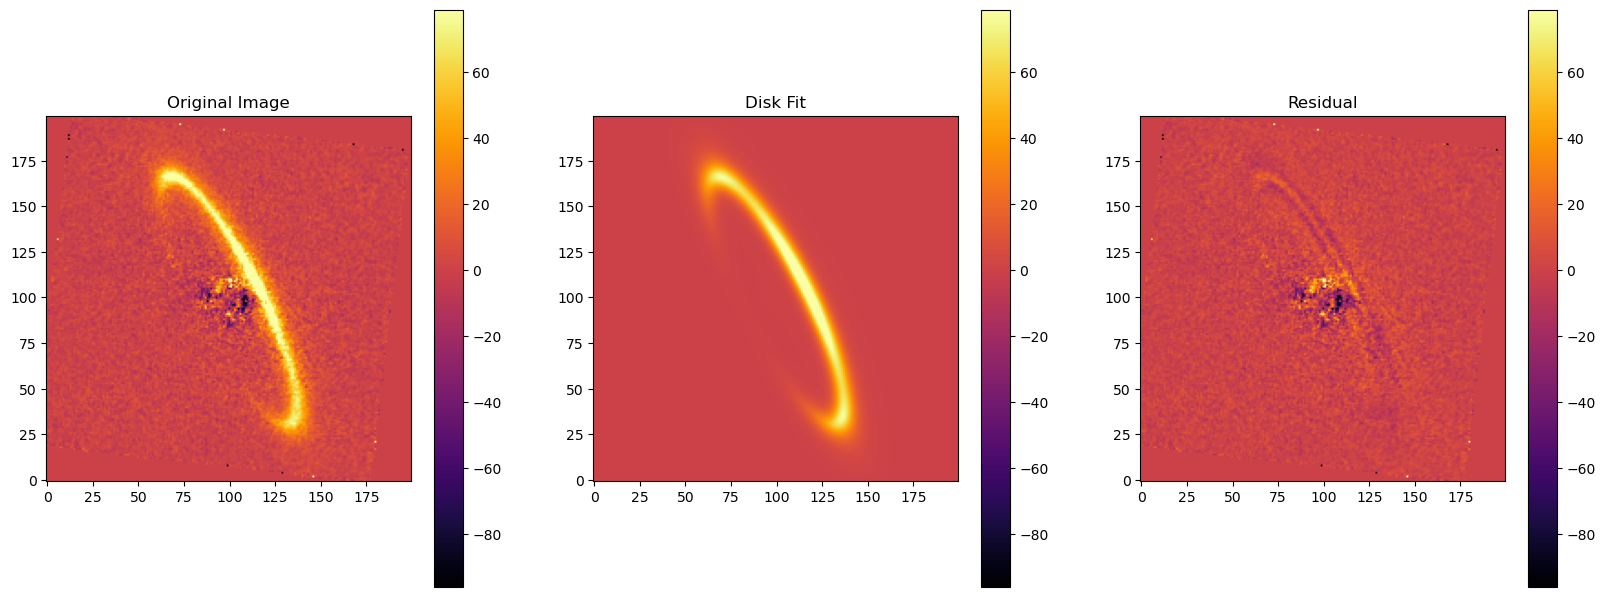

In [15]:
fig, axes = plt.subplots(1,3, figsize=(20,10))

mask = OptimizeUtils.get_mask(target_image)
vmin = np.nanpercentile(target_image[mask], 1)
vmax = np.nanpercentile(target_image[mask], 99)

im = axes[0].imshow(target_image, origin='lower', cmap='inferno')
axes[0].set_title("Original Image")
plt.colorbar(im, ax=axes[0], shrink=0.75)
im.set_clim(vmin, vmax)

im = axes[1].imshow(optimal_image, origin='lower', cmap='inferno')
axes[1].set_title("Disk Fit")
plt.colorbar(im, ax=axes[1], shrink=0.75)
im.set_clim(vmin, vmax)

im = axes[2].imshow(target_image-optimal_image, origin='lower', cmap='inferno')
axes[2].set_title("Residual")
plt.colorbar(im, ax=axes[2], shrink=0.75)
im.set_clim(vmin, vmax)

In [16]:
opt.scale_spline_to_fixed_point(0, 1)
opt.print_params()

Disk Params: {'accuracy': 0.005, 'alpha_in': np.float64(20.0), 'alpha_out': np.float64(-12.739395791995065), 'sma': np.float64(77.56102693972802), 'e': np.float64(0.0), 'ksi0': 3.0, 'gamma': 2.0, 'beta': 1.0, 'rmin': 0.0, 'dens_at_r0': 1.0, 'inclination': np.float64(76.33804928843712), 'position_angle': np.float64(26.678114192576466), 'x_center': np.float64(102.43888306055123), 'y_center': np.float64(101.45739818630041), 'halfNbSlices': 25, 'omega': 0.0}
SPF Params: {'backscatt_bound': Array(-0.97236992, dtype=float64, weak_type=True), 'forwardscatt_bound': Array(0.97236992, dtype=float64, weak_type=True), 'num_knots': 7, 'knot_values': Array([3.66973631, 1.68541658, 1.48020561, 1.        , 0.6965197 ,
       0.29584594, 0.0072989 ], dtype=float64)}
PSF Params: {'scale_factor': 1.0, 'offset': 1.0}
Stellar PSF Params: None
Misc Params: {'distance': 72.78, 'pxInArcsec': 0.01414, 'nx': 200, 'ny': 200, 'halfNbSlices': 25, 'flux_scaling': Array(21886.58575947, dtype=float64)}


## Running MCMC

In [17]:
# For MCMC, spline values are log scaled, the optimizer class passes them in as log(spf_params) and they are exponated in the lambda expression, this evens out the markov chains
# helping MCMC work better

fit_keys = ['alpha_in', 'alpha_out', 'sma', 'inclination', 'position_angle', 'x_center', 'y_center', 'knot_values', 'e']
logscaled_params = ['knot_values']
array_params = ['knot_values']
bounds = ([0.1, -15, 0, 0, 0, 90, 90, np.zeros(7), 0],
          [200, -0.1, 150, 180, 400, 110, 110, 1e4*np.ones(7), 1])

mc_model = opt.mcmc(fit_keys, logscaled_params, array_params, target_image, err_map, bounds, nwalkers=100, niter=100, burns=20)

Overwriting the previous backend...
Running burn-in...


100%|██████████| 20/20 [00:08<00:00,  2.42it/s]


Running production...


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


In [18]:
mc_soln = mc_model.get_theta_median(scaled = True)
img = opt.get_model()

Text(0.5, 1.0, 'Post MCMC')

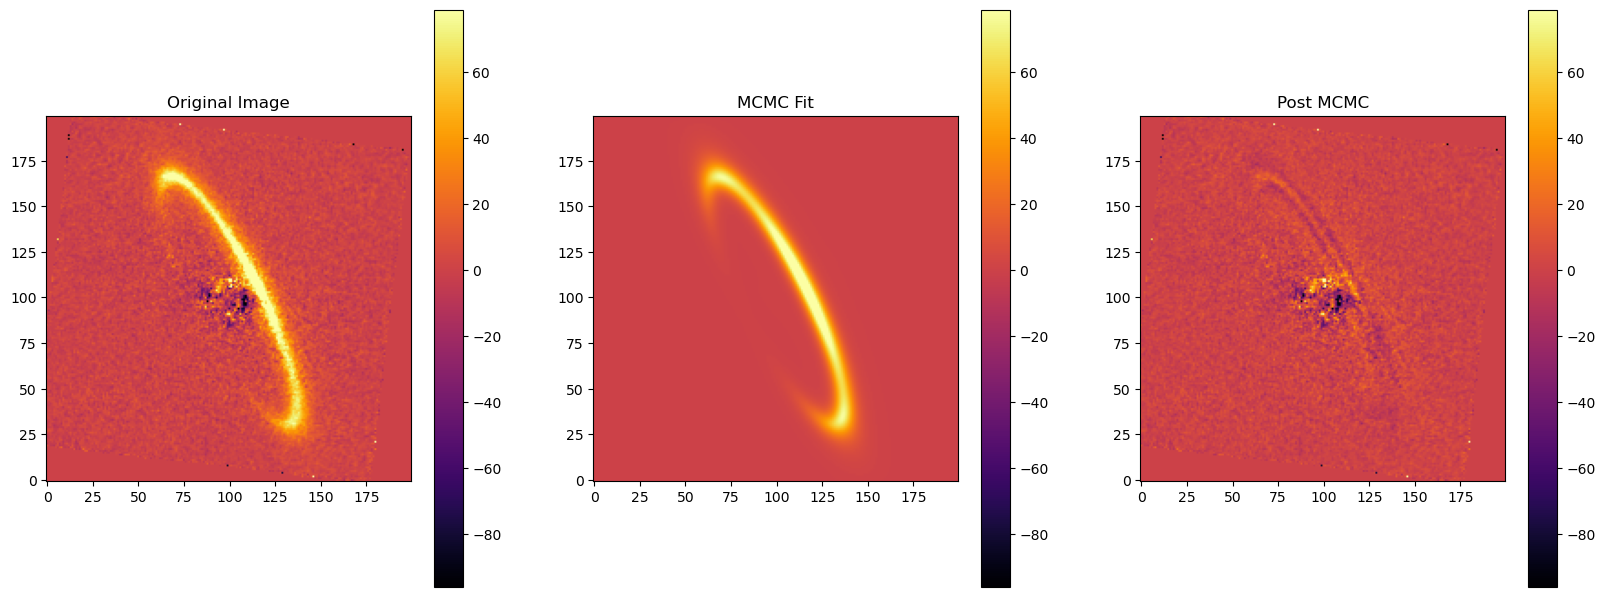

In [19]:
fig, axes = plt.subplots(1,3, figsize=(20,10))

mask = OptimizeUtils.get_mask(target_image)
vmin = np.nanpercentile(target_image[mask], 1)
vmax = np.nanpercentile(target_image[mask], 99)

im = axes[0].imshow(target_image, origin='lower', cmap='inferno')
axes[0].set_title("Original Image")
plt.colorbar(im, ax=axes[0], shrink=0.75)
im.set_clim(vmin, vmax)

im = axes[1].imshow(img, origin='lower', cmap='inferno')
axes[1].set_title("MCMC Fit")
plt.colorbar(im, ax=axes[1], shrink=0.75)
im.set_clim(vmin, vmax)

im = axes[2].imshow(target_image-img, origin='lower', cmap='inferno')
axes[2].set_title("Residual")
plt.colorbar(im, ax=axes[2], shrink=0.75)
im.set_clim(vmin, vmax)
plt.title("Post MCMC")

### Plotting MCMC Results

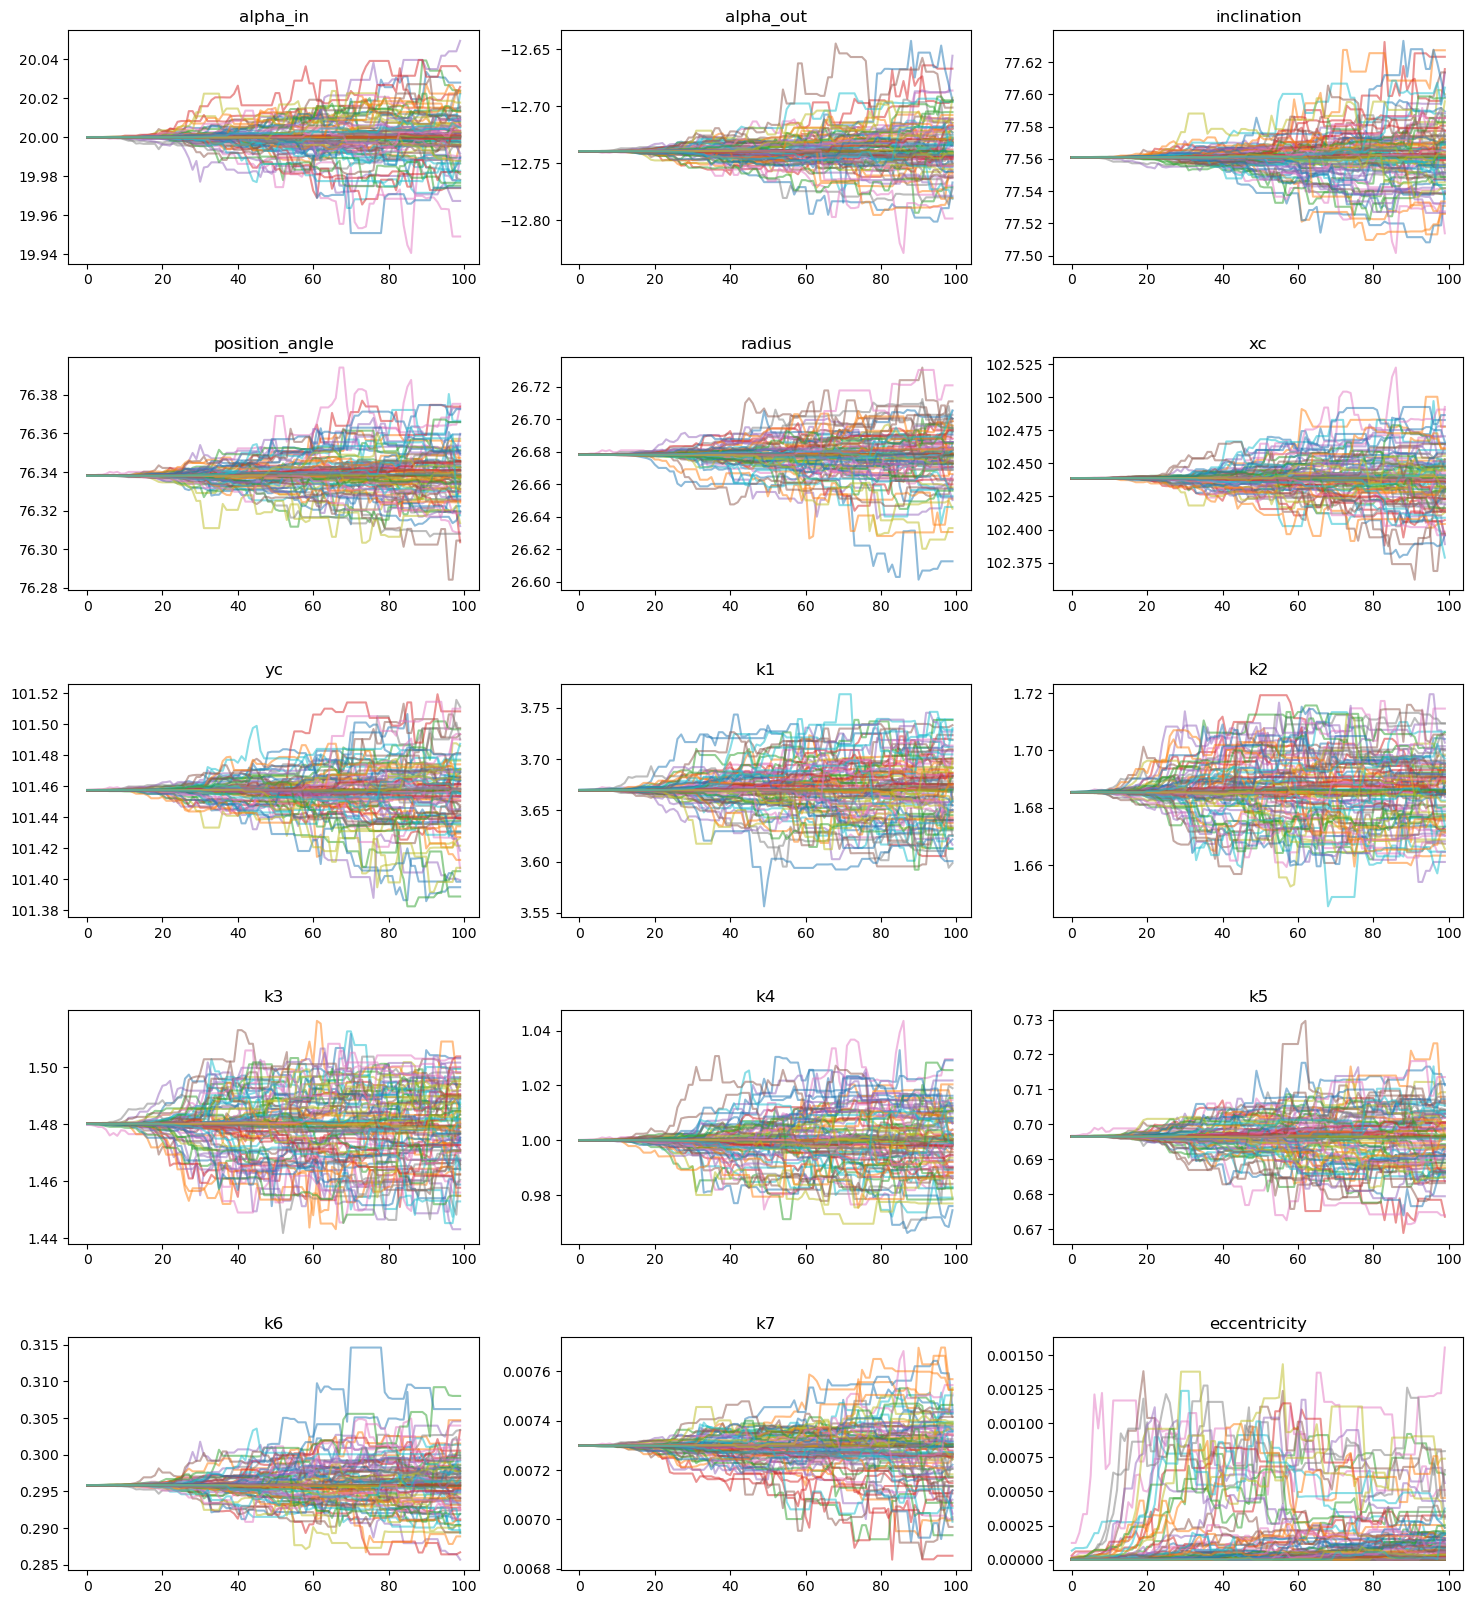

In [20]:
labels = ['alpha_in', 'alpha_out', 'inclination', 'position_angle', 'radius', 'xc', 'yc']
for i in range(0, opt.spf_params['num_knots']):
    labels.append('k'+str(i+1))
labels.append('eccentricity')
mc_model.plot_chains(labels, scaled = True)

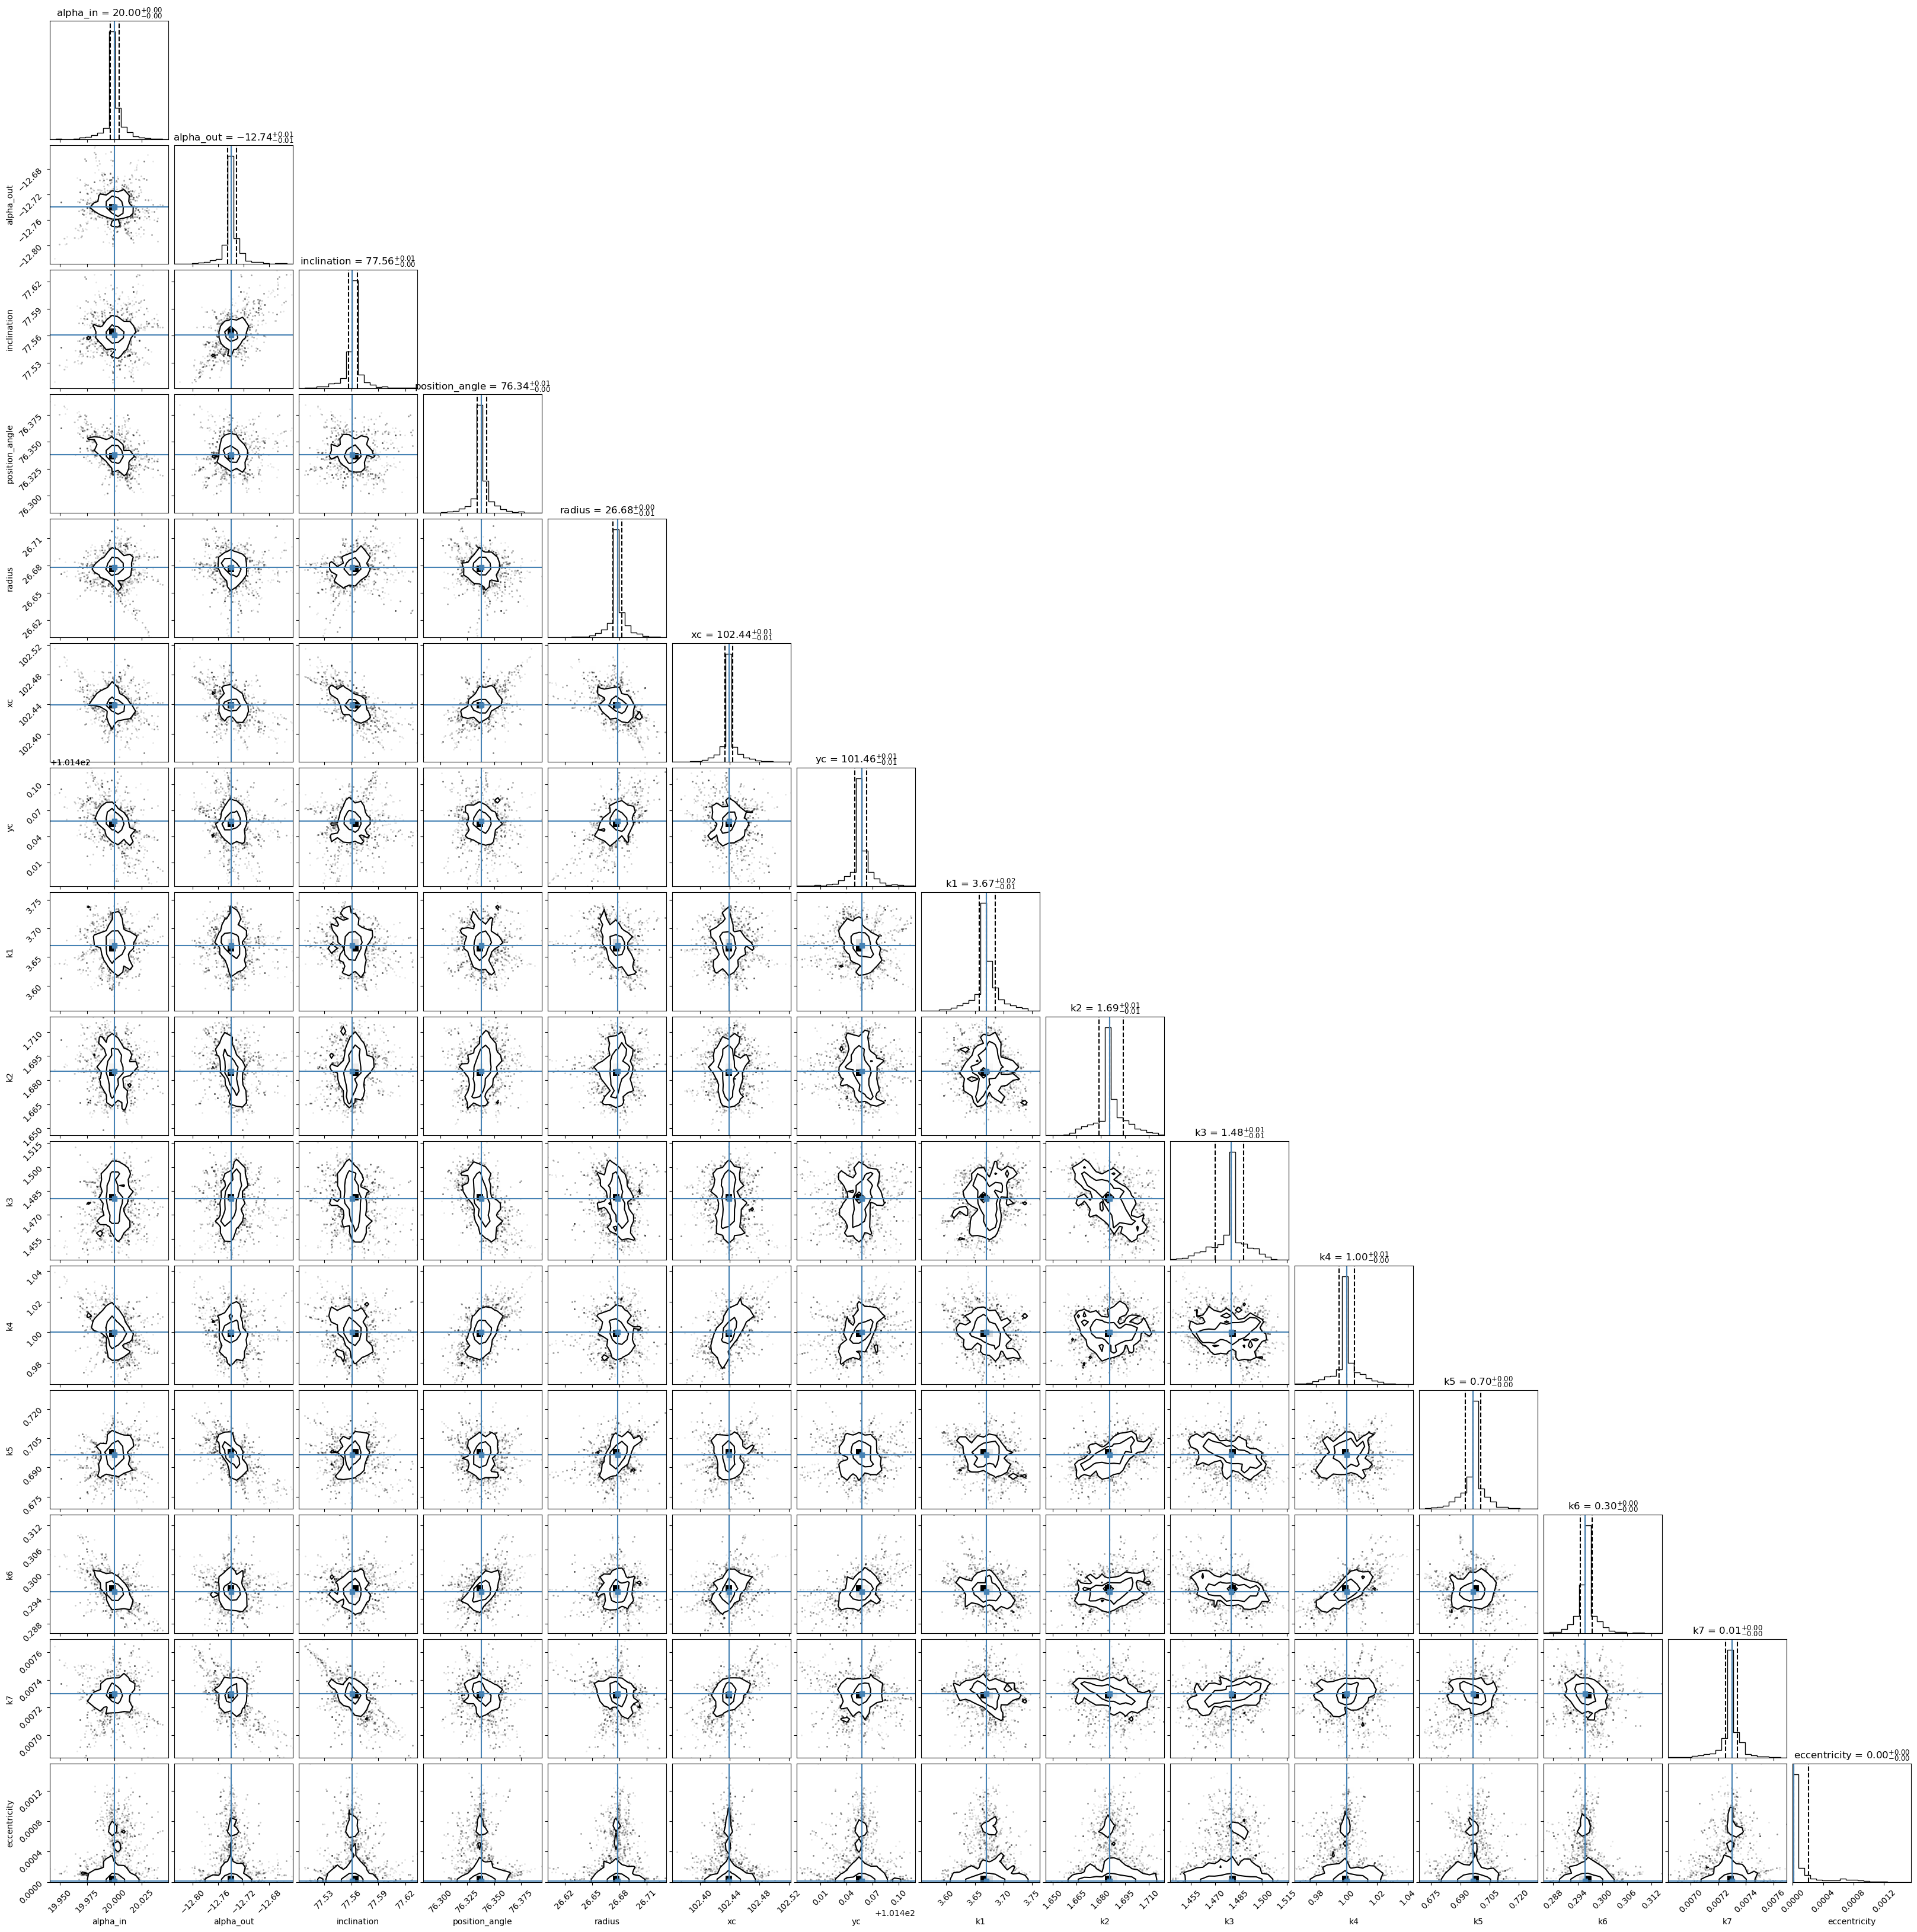

In [21]:
mc_model.show_corner_plot(labels, truths=mc_soln, scaled = True, quiet = True)

In [22]:
print(mc_model.get_theta_median(scaled = True))
print(labels)

[ 2.00000000e+01 -1.27393957e+01  7.75610292e+01  7.63380537e+01
  2.66781155e+01  1.02438882e+02  1.01457392e+02  3.66974172e+00
  1.68543853e+00  1.48020234e+00  9.99996943e-01  6.96519562e-01
  2.95845539e-01  7.29887811e-03  1.51905926e-05]
['alpha_in', 'alpha_out', 'inclination', 'position_angle', 'radius', 'xc', 'yc', 'k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'eccentricity']
